# MCMRI Preprocessing

## Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Functions

In [0]:
# https://github.com/ismrmrd/ismrmrd-python-tools/blob/master/ismrmrdtools/transform.py

from numpy.fft import fftshift, ifftshift, fftn, ifftn

def transform_image_to_kspace(img, dim=None, k_shape=None):
    """ Computes the Fourier transform from image space to k-space space
    along a given or all dimensions
    :param img: image space data
    :param dim: vector of dimensions to transform
    :param k_shape: desired shape of output k-space data
    :returns: data in k-space (along transformed dimensions)
    """
    if not dim:
        dim = range(img.ndim)

    k = fftshift(fftn(ifftshift(img, axes=dim), s=k_shape, axes=dim), axes=dim)
    k /= np.sqrt(np.prod(np.take(img.shape, dim)))
    return k

def transform_kspace_to_image(k, dim=None, img_shape=None):
    """ Computes the Fourier transform from k-space to image space
    along a given or all dimensions
    :param k: k-space data
    :param dim: vector of dimensions to transform
    :param img_shape: desired shape of output image
    :returns: data in image space (along transformed dimensions)
    """
    if not dim:
        dim = range(k.ndim)

    img = fftshift(ifftn(ifftshift(k, axes=dim), s=img_shape, axes=dim), axes=dim)
    img *= np.sqrt(np.prod(np.take(img.shape, dim)))
    return img

In [0]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cv2

def show_img(img):
  plt.imshow(abs(img), cmap='gray')
  plt.axis('off')
  plt.show()

def show_ksp(ksp):
  plt.imshow(np.log(np.abs(ksp[0])), cmap='gray')
  plt.axis('off')
  plt.show()

def sense_forw(img, maps, mask=1):
  maps_forw = img*maps
  fft_forw = transform_image_to_kspace(maps_forw, dim=(1,2))
  mask_forw = fft_forw*mask
  return mask_forw

def sense_adj(ksp, maps, mask=1):
  mask_forw = ksp*mask
  fft_adj = transform_kspace_to_image(mask_forw, dim=(1,2))
  maps_adj = np.sum(np.conj(maps)*fft_adj, axis=0)
  return maps_adj

def bit_scale(x, bits):
  return cv2.normalize(abs(x), None, 0, (2**bits)-1, cv2.NORM_MINMAX, cv2.CV_8U)

def zero_one_scale(x, bits):
  s = (2**bits)-1
  return cv2.normalize(abs(x), None, 0, (2**bits)-1, cv2.NORM_MINMAX, cv2.CV_8U)/s

def size_scale(img, scale):
  dim_rev = np.rint(np.array(img.shape)*scale).astype(int)
  dim = (dim_rev[1], dim_rev[0])
  return cv2.resize(abs(img), dim, interpolation=cv2.INTER_AREA)

def size_scale_maps(maps, scale):
  dim_rev = np.rint(np.array(maps[0].shape)*scale).astype(int)
  dim = (dim_rev[1], dim_rev[0])
  s_maps = []
  for m in maps:
    real = cv2.resize(m.real, dim, interpolation=cv2.INTER_AREA)
    imag = cv2.resize(m.imag, dim, interpolation=cv2.INTER_AREA)
    s_maps.append(np.vectorize(complex)(real, imag))
  return np.array(s_maps)

def size_scale_mask(mask, scale):
  dim_rev = np.rint(np.array(mask.shape)*scale).astype(int)
  dim = (dim_rev[1], dim_rev[0])
  return cv2.resize(mask, dim, interpolation=cv2.INTER_NEAREST)

def scale_all(img, maps, mask, scale, bits=None, zero_one=False):
  if scale != 1:
    img = size_scale(img, scale)
    maps = size_scale_maps(maps, scale)
    mask = size_scale_mask(mask, scale)
  if bits is not None:
    if zero_one:
      img = zero_one_scale(img, bits)
    else:
      img = bit_scale(img, bits)
  return img, maps, mask

def test_transforms(img, maps, mask, ksp=None):
  print('img')
  show_img(img)

  t_img = sense_forw(img, maps)
  print('img->ksp')
  show_ksp(t_img)

  tt_img = sense_adj(t_img, maps)
  print('img->ksp->img')
  show_img(tt_img)

  tmt_img = sense_adj(t_img, maps, mask)
  print('img->ksp->mask->img')
  show_img(tmt_img)

  if ksp is not None:
    t_ksp = sense_adj(ksp, maps)
    print('ksp->img')
    show_img(t_ksp)

    tm_ksp = sense_adj(ksp, maps, mask)
    print('ksp->mask->img')
    show_img(tm_ksp)

## Loading Data

In [4]:
root = "drive/Shared drives/EE 461P Project/Dataset/dataset_train_knees.h5"
data = h5py.File(root, "r")
print(data.keys())

<KeysViewHDF5 ['imgs', 'ksp', 'maps', 'masks']>


In [5]:
imgs = data['imgs']
ksp = data['ksp']
maps = data['maps']
masks = data['masks']
print(imgs.shape)
print(imgs.dtype)
print(ksp.shape)
print(ksp.dtype)
print(maps.shape)
print(maps.dtype)
print(masks.shape)
print(masks.dtype)

(4480, 256, 320)
complex64
(4480, 8, 256, 320)
complex64
(4480, 8, 256, 320)
complex64
(4480, 256, 320)
float64


## Forward and Adjoint Sensing

img


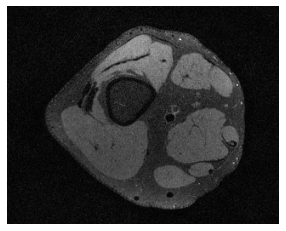

ksp


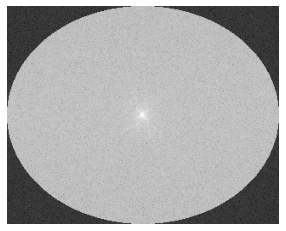

img->ksp


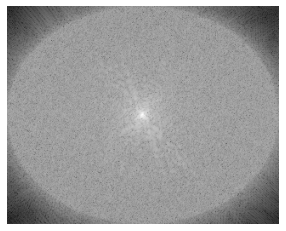

img->ksp->img


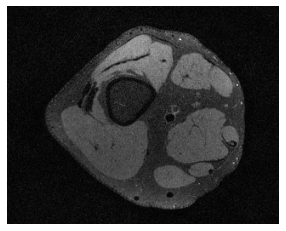

img->ksp->mask->img


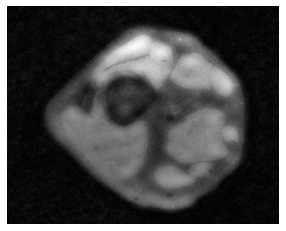

ksp->img


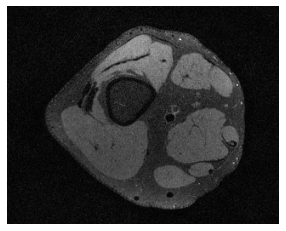

ksp->mask->img


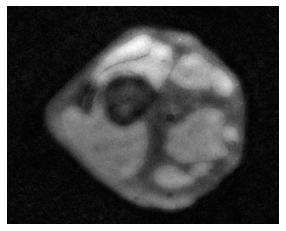

In [9]:
print('img')
show_img(imgs[0])
print('ksp')
show_ksp(ksp[0])

t_img = sense_forw(imgs[0], maps[0])
print('img->ksp')
show_ksp(t_img)
tt_img = sense_adj(t_img, maps[0])
print('img->ksp->img')
show_img(tt_img)

tm_img = sense_forw(imgs[0], maps[0], masks[0])
tmt_img = sense_adj(tm_img, maps[0])
print('img->ksp->mask->img')
show_img(tmt_img)

t_ksp = sense_adj(ksp[0], maps[0])
print('ksp->img')
show_img(t_ksp)

tm_ksp = sense_adj(ksp[0], maps[0], masks[0])
print('ksp->mask->img')
show_img(tm_ksp)

The above demonstrates transforming from image space to kspace and back with and without the mask applied.

## Testing Bit Scaling

### Bit Scaling Image

img->5bit


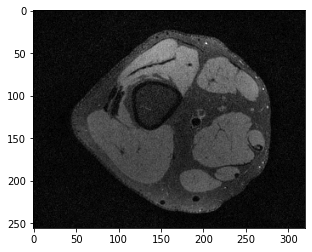

img->5bit->ksp


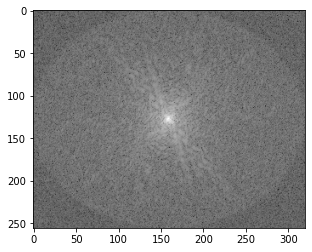

img->5bit->ksp->img


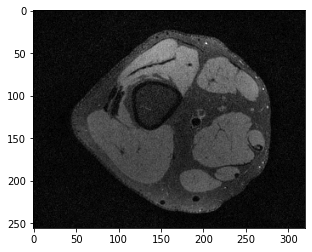

max: 31.000000386475925
min: 1.545946077261241e-17

img->5bit->ksp->mask->img


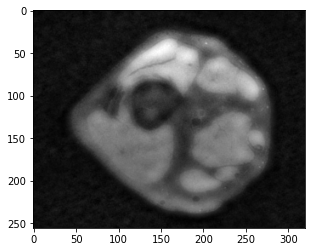

max: 19.629034141387585
min: 0.06554448039298562



In [0]:
img = bit_scale(imgs[0], 5)
print('img->5bit')
show_img(img)

t_img = sense_forw(img, maps[0])
print('img->5bit->ksp')
show_ksp(t_img)

tt_img = sense_adj(t_img, maps[0])
print('img->5bit->ksp->img')
show_img(tt_img)
print('max: ' + str(abs(tt_img).max()))
print('min: ' + str(abs(tt_img).min()) + '\n')

tm_img = sense_forw(img, maps[0], masks[0])
tmt_img = sense_adj(tm_img, maps[0])
print('img->5bit->ksp->mask->img')
show_img(tmt_img)
print('max: ' + str(abs(tmt_img).max()))
print('min: ' + str(abs(tmt_img).min()) + '\n')

The above demonstrates that scaling the image to a five bit representation does not deprecate the transformations. One thing to note is that converting a five bit image to k-space, masking the k-space, and converting back to a noise-aliased image does not maintain the range of 0 to 31 of norm values. This should not pose a major problem, as the doubly transformed noisy-aliased image can simply be rescaled.

### Zero-One Scaling Image

img->01


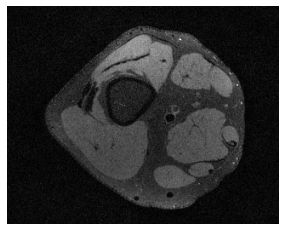

img->01->ksp


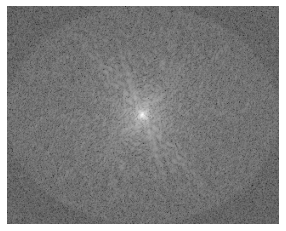

img->01->ksp->img


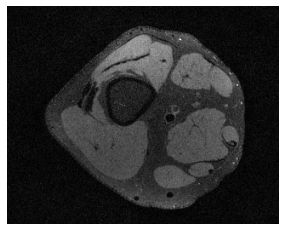

In [10]:
img = zero_one_scale(imgs[0], 5)
print('img->01')
show_img(img)

t_img = sense_forw(img, maps[0])
print('img->01->ksp')
show_ksp(t_img)

tt_img = sense_adj(t_img, maps[0])
print('img->01->ksp->img')
show_img(tt_img)

The above demonstrates that zero one scaling with five bits does not deprecate the transformation, and is just a transformation from normal five bit scaling.

### Bit Scaling Maps

img->5bit


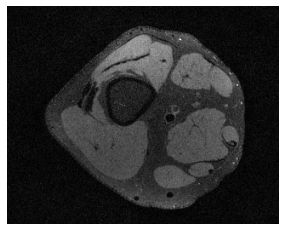

img->5bit->ksp (with 5bit maps)


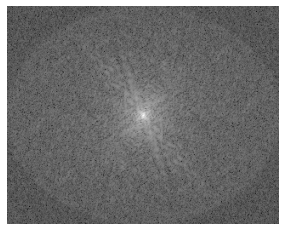

img->5bit->ksp->img (with 5bit maps)


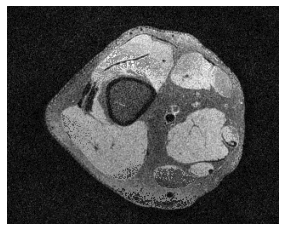

In [12]:
img = bit_scale(imgs[0], 5)
s_maps = bit_scale(maps[0], 5)

print('img->5bit')
show_img(img)

t_img = sense_forw(img, s_maps)
print('img->5bit->ksp (with 5bit maps)')
show_ksp(t_img)

tt_img = sense_adj(t_img, s_maps)
print('img->5bit->ksp->img (with 5bit maps)')
show_img(tt_img)

The above demonstrates that scaling the maps to a five bit representation deprecates the transformation. The information stored by the imaginary component of the maps seems to be necessary for maintaining the foward and adjoint sensing transformations.

## Testing Size Scaling

### Size Scaling Image

full img


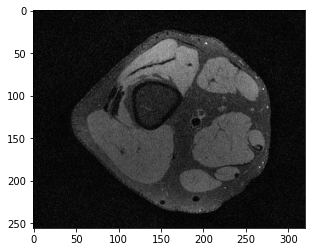

1/2 size img


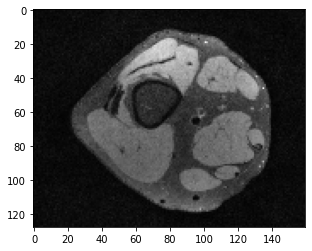

1/4 size img


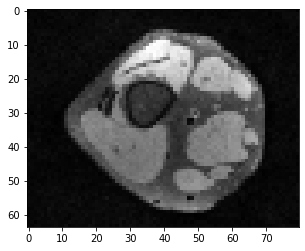

1/8 size img


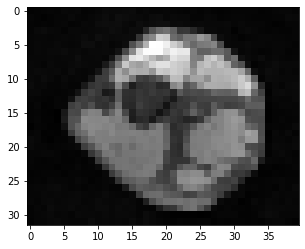

In [0]:
print('full img')
show_img(imgs[0])

s2_img = size_scale(imgs[0], 1/2)
print('1/2 size img')
show_img(s2_img)

s4_img = size_scale(imgs[0], 1/4)
print('1/4 size img')
show_img(s4_img)

s8_img = size_scale(imgs[0], 1/8)
print('1/8 size img')
show_img(s8_img)

The above demonstrates the affect of scaling down the mri images. 1/2 size still looks good, 1/4 size loses some quality, and 1/8 size definitely loses too much quality.

### Size Scaling Maps

full map


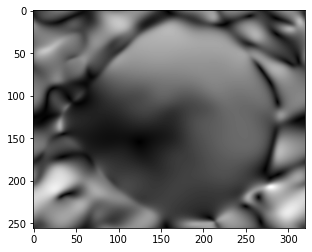

1/2 size map


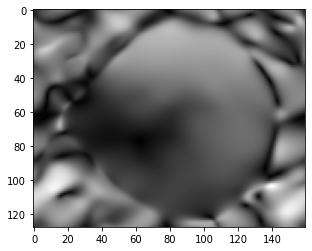

1/4 size map


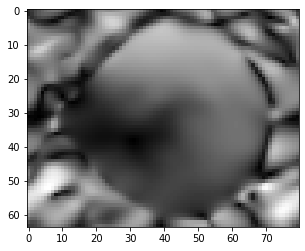

1/8 size map


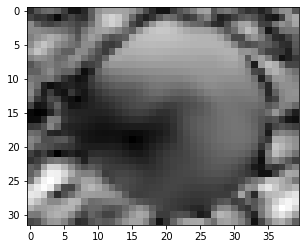

In [0]:
print('full map')
show_img(maps[0][0])

s2_maps = size_scale_maps(maps[0], 1/2)
print('1/2 size map')
show_img(s2_maps[0])

s4_maps = size_scale_maps(maps[0], 1/4)
print('1/4 size map')
show_img(s4_maps[0])

s8_maps = size_scale_maps(maps[0], 1/8)
print('1/8 size map')
show_img(s8_maps[0])

Resizing the maps was a bit weird since it required resizing the real and complex portions separately, but it seems to work.

### Size Scaling Mask

full mask


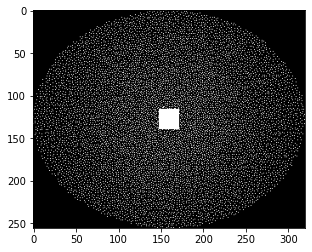

1/2 size mask


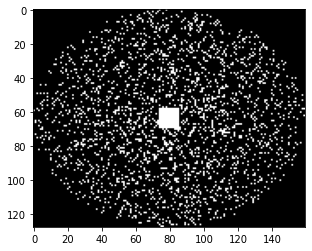

1/4 size mask


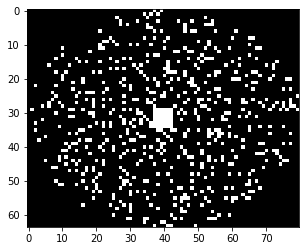

1/8 size mask


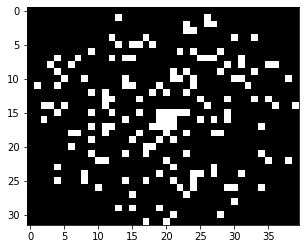

In [0]:
print('full mask')
show_img(masks[0])

s2_mask = size_scale_mask(masks[0], 1/2)
print('1/2 size mask')
show_img(s2_mask)

s4_mask = size_scale_mask(masks[0], 1/4)
print('1/4 size mask')
show_img(s4_mask)

s8_mask = size_scale_mask(masks[0], 1/8)
print('1/8 size mask')
show_img(s8_mask)

Resizing the mask is possible with a different interpolation method. It appears like this may deprecate the image transforms, so other techniques may need to be tried.

## Testing Forward and Adjoint Transforms after Resizing

### Scaling Factor of 1/2

img


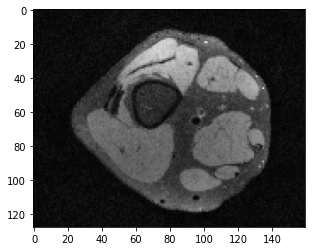

img->ksp


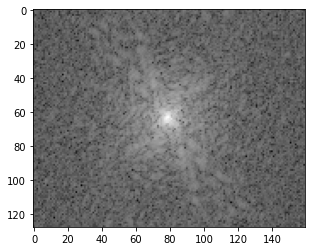

img->ksp->img


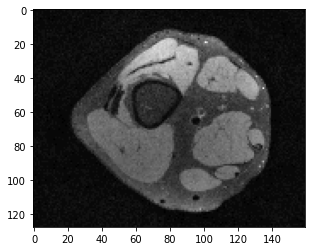

img->ksp->mask->img


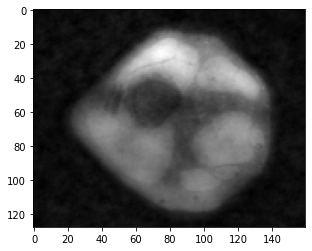

In [0]:
factor = 1/2
bits=5
s_img, s_maps, s_mask = scale_all(imgs[0], maps[0], masks[0], factor, bits)
test_transforms(s_img, s_maps, s_mask)

### Scaling Factor of 1/4

img


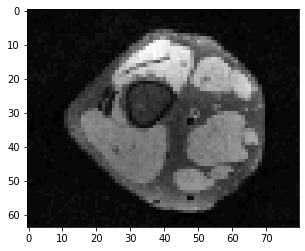

img->ksp


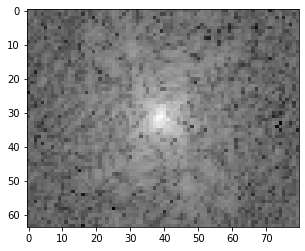

img->ksp->img


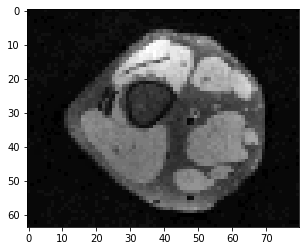

img->ksp->mask->img


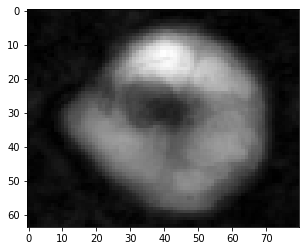

In [0]:
factor = 1/4
s_img, s_maps, s_mask = scale_all(imgs[0], maps[0], masks[0], factor, bits)
test_transforms(s_img, s_maps, s_mask)

### Scaling Factor of 1/8

img


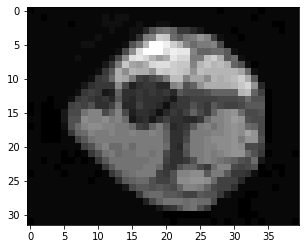

img->ksp


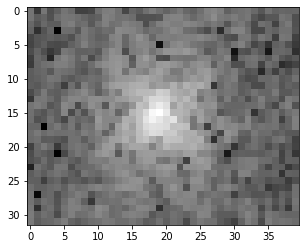

img->ksp->img


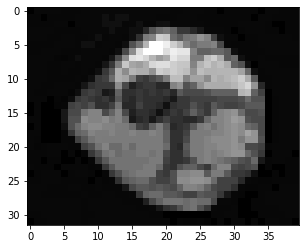

img->ksp->mask->img


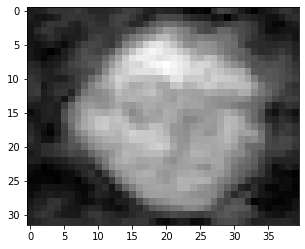

In [0]:
factor = 1/4.5
s_img, s_maps, s_mask = scale_all(imgs[0], maps[0], masks[0], factor, bits)
test_transforms(s_img, s_maps, s_mask)

The scaled maps seem to work very well for the transformations, but the masks could use some work since the smaller the scale, the more unreadable the image becomes.

## Testing Forward and Adjoint Transforms after Resizing and Bit Scaling

### 8 Bits with Scale Factor of 1

img


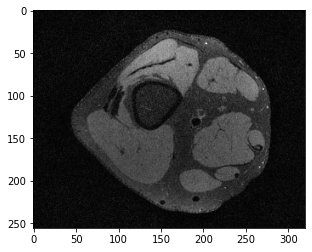

img->ksp


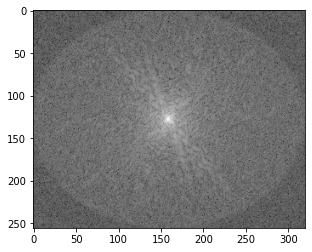

img->ksp->img


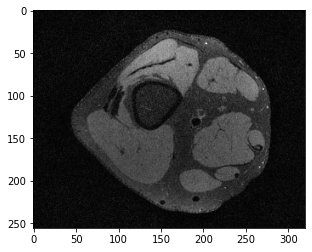

img->ksp->mask->img


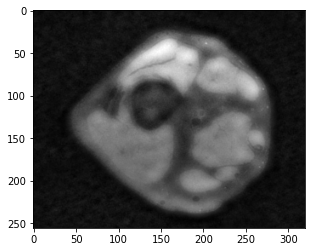

In [0]:
factor = 1
bits = 8
s_img, s_maps, s_mask = scale_all(imgs[0], maps[0], masks[0], factor, bits)
test_transforms(s_img, s_maps, s_mask)

### 5 bits with Scale Factor of 1/4

img


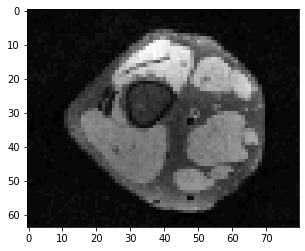

img->ksp


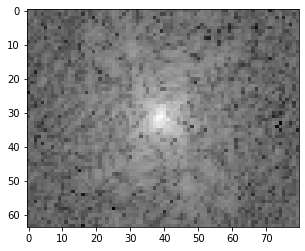

img->ksp->img


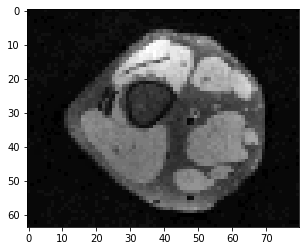

img->ksp->mask->img


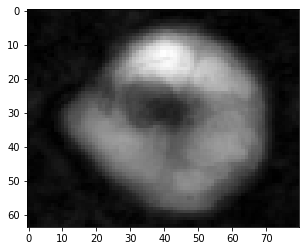

In [0]:
factor = 1/4
bits = 5
s_img, s_maps, s_mask = scale_all(imgs[0], maps[0], masks[0], factor, bits)
test_transforms(s_img, s_maps, s_mask)

Bit scaling and size scaling seem to work with each other.

## Preprocessing Data

In [0]:
def process_data(in_path, out_path, bits=8, scale=1, transpose=True, zero_one=True, data_range=None):
  data = h5py.File(in_path, "r")

  if data_range is None:
    imgs = np.array(data['imgs'])
    maps = np.array(data['maps'])
    masks = np.array(data['masks'])
  else:
    imgs = np.array(data['imgs'][data_range[0]:data_range[1]:data_range[2]])
    maps = np.array(data['maps'][data_range[0]:data_range[1]:data_range[2]])
    masks = np.array(data['masks'][data_range[0]:data_range[1]:data_range[2]])

  proc_imgs = []
  proc_ksp = []
  proc_maps = []
  proc_masks = []

  for i in range(len(imgs)):
    if i%100 == 0:
      print('processing image ' + str(i))
    if transpose:
      s_img = imgs[i].transpose()
      s_mask = masks[i].transpose()
      s_maps = []
      for m in maps[i]:
        s_maps.append(m.transpose())
      s_maps = np.array(s_maps)
    else:
      s_img = imgs[i]
      s_maps = maps[i]
      s_mask = masks[i]

    s_img, s_maps, s_mask = scale_all(s_img, s_maps, s_mask, scale, bits, zero_one)
    s_ksp = sense_forw(s_img, s_maps)
    
    proc_imgs.append(s_img)
    proc_ksp.append(s_ksp)
    proc_maps.append(s_maps)
    proc_masks.append(s_mask)

  proc_imgs = np.array(proc_imgs)
  proc_ksp = np.array(proc_ksp)
  proc_maps = np.array(proc_maps)
  proc_masks = np.array(proc_masks)

  data = h5py.File(out_path, "w")
  data.create_dataset('imgs', data=proc_imgs)
  data.create_dataset('ksp', data=proc_ksp)
  data.create_dataset('maps', data=proc_maps)
  data.create_dataset('masks', data=proc_masks)
  data.close()

  return data

### Final Preprocessing

In [0]:
in_path = "drive/Shared drives/EE 461P Project/Dataset/dataset_train_knees.h5"
out_path = "drive/Shared drives/EE 461P Project/Dataset/8bit_knees_full.h5"

data = process_data(in_path, out_path, data_range=(0,1500,100))
read = h5py.File(out_path, "r")

processing image 0


In [0]:
in_path = "drive/Shared drives/EE 461P Project/Dataset/dataset_train_knees.h5"
out_path = "drive/Shared drives/EE 461P Project/Dataset/4bit_knees_full.h5"

data = process_data(in_path, out_path, bits=4, data_range=(0,1500,100))
read = h5py.File(out_path, "r")

processing image 0


In [0]:
in_path = "drive/Shared drives/EE 461P Project/Dataset/dataset_train_knees.h5"
out_path = "drive/Shared drives/EE 461P Project/Dataset/8bit_knees_scaled.h5"

data = process_data(in_path, out_path, scale=1/4, data_range=(0,1500,100))
read = h5py.File(out_path, "r")

processing image 0


In [0]:
in_path = "drive/Shared drives/EE 461P Project/Dataset/dataset_train_knees.h5"
out_path = "drive/Shared drives/EE 461P Project/Dataset/4bit_knees_scaled.h5"

data = process_data(in_path, out_path, bits=4, scale=1/4, data_range=(0,1500,100))
read = h5py.File(out_path, "r")

processing image 0
